# Download data and libraries

In [ ]:
!pip install -Uqq underthesea

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 14.1 MB/s eta 0:00:00


In [ ]:
# Install PyDrive
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_ids = {
    'word2vec.txt': '1L9DdOOeonW_PpZ7ixuS-WtgXhE7GbOwA'
}

# Download file
for filename, file_id in file_ids.items():
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(filename)
    print(f"Downloaded {filename}")


Downloaded word2vec.txt


# Load pretrained Vietnamese word2vec

In [ ]:
import torch
import torchtext.vocab as vocab

word_embedding = vocab.Vectors(name = "word2vec.txt",
                               unk_init = torch.Tensor.normal_)

word_embedding.vectors.shape

In [ ]:
def get_vector(embeddings, word):
    """ Get embedding vector of the word
    @param embeddings (torchtext.vocab.vectors.Vectors)
    @param word (str)
    @return vector (torch.Tensor)
    """
    assert word in embeddings.stoi, f'*{word}* is not in the vocab!'
    return embeddings.vectors[embeddings.stoi[word]]

def closest_words(embeddings, vector, n=10):
    """ Return n words closest in meaning to the word
    @param embeddings (torchtext.vocab.vectors.Vectors)
    @param vector (torch.Tensor)
    @param n (int)
    @return words (list(tuple(str, float)))
    """
    distances = [(word, torch.dist(vector, get_vector(embeddings, word)).item())
                 for word in embeddings.itos]

    return sorted(distances, key = lambda w: w[1])[:n]


# Vocabulary.py

In [ ]:
import torch
from underthesea import word_tokenize


class Vocabulary:
    """ The Vocabulary class is used to record words, which are used to convert
        text to numbers and vice versa.
    """

    def __init__(self):
        self.word2id = dict()
        self.word2id['<pad>'] = 0   # Pad Token
        self.word2id['<unk>'] = 1   # Unknown Token
        self.unk_id = self.word2id['<unk>']
        self.id2word = {v: k for k, v in self.word2id.items()}

    def __getitem__(self, word):
        return self.word2id.get(word, self.unk_id)

    def __contains__(self, word):
        return word in self.word2id

    def __len__(self):
        return len(self.word2id)

    def id2word(self, word_index):
        """
        @param word_index (int)
        @return word (str)
        """
        return self.id2word[word_index]

    def add(self, word):
        """ Add word to vocabulary
        @param word (str)
        @return index (str): index of the word just added
        """
        if word not in self:
            word_index = self.word2id[word] = len(self.word2id)
            self.id2word[word_index] = word
            return word_index
        else:
            return self[word]

    @staticmethod
    def tokenize_corpus(corpus):
        """Split the documents of the corpus into words
        @param corpus (list(str)): list of documents
        @return tokenized_corpus (list(list(str))): list of words
        """
        tokenized_corpus = list()
        for document in corpus:
            tokenized_document = [word.replace(" ", "_") for word in word_tokenize(document)]
            tokenized_corpus.append(tokenized_document)

        return tokenized_corpus

    def corpus_to_tensor(self, corpus, is_tokenized=False):
        """ Convert corpus to a list of indices tensor
        @param corpus (list(str) if is_tokenized==False else list(list(str)))
        @param is_tokenized (bool)
        @return indicies_corpus (list(tensor))
        """
        if is_tokenized:
            tokenized_corpus = corpus
        else:
            tokenized_corpus = self.tokenize_corpus(corpus)
        indicies_corpus = list()
        for document in tokenized_corpus:
            indicies_document = torch.tensor(list(map(lambda word: self[word], document)),
                                             dtype=torch.int64)
            indicies_corpus.append(indicies_document)

        return indicies_corpus

    def tensor_to_corpus(self, tensor):
        """ Convert list of indices tensor to a list of tokenized documents
        @param indicies_corpus (list(tensor))
        @return corpus (list(list(str)))
        """
        corpus = list()
        for indicies in tensor:
            document = list(map(lambda index: self.id2word[index.item()], indicies))
            corpus.append(document)

        return corpus


In [ ]:
vocab = Vocabulary()

# create vocabulary from pretrained word2vec
words_list = list(word_embedding.stoi.keys())
for word in words_list:
    vocab.add(word)

# Dataset

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset


class Dataset(Dataset):
    """ Load dataset from file csv"""

    def __init__(self, vocab, csv_fpath=None, tokenized_fpath=None):
        """
        @param vocab (Vocabulary)
        @param csv_fpath (str)
        @param tokenized_fpath (str)
        """
        self.vocab = vocab
        self.pad_idx = vocab["<pad>"]
        df = pd.read_csv(csv_fpath)
        self.sentiments_list = list(df.sentiment)
        self.reviews_list = list(df.vi_review)

        sentiments_type = list(set(self.sentiments_list))
        sentiments_type.sort()

        self.sentiment2id = {sentiment: i for i, sentiment in enumerate(sentiments_type)}

        if tokenized_fpath:
            self.tokenized_reviews = torch.load(tokenized_fpath)
        else:
            self.tokenized_reviews = self.vocab.tokenize_corpus(self.reviews_list)

        self.tensor_data = self.vocab.corpus_to_tensor(self.tokenized_reviews, is_tokenized=True)
        self.tensor_label = torch.tensor([self.sentiment2id[sentiment] for sentiment in self.sentiments_list],
                                         dtype=torch.float64)

    def __len__(self):
        return len(self.tensor_data)

    def __getitem__(self, idx):
        return self.tensor_data[idx], self.tensor_label[idx]

    def collate_fn(self, examples):
        examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)

        reviews = [e[0] for e in examples]
        reviews = torch.nn.utils.rnn.pad_sequence(reviews,
                                                  batch_first=False,
                                                  padding_value=self.pad_idx)
        reviews_lengths = torch.tensor([len(e[0]) for e in examples])
        sentiments = torch.tensor([e[1] for e in examples])

        return {"reviews": (reviews, reviews_lengths), "sentiments": sentiments}

In [ ]:
dataset = Dataset(vocab, "dataset.csv")

In [ ]:
torch.save(dataset.tokenized_reviews, "tokenized.pt")

# Split data

In [ ]:
from torch.utils.data import random_split


split_rate = 0.83
full_size = len(dataset)
train_size = (int)(split_rate * full_size)
valid_size = (full_size - train_size)

train_dataset, valid_dataset = random_split(dataset,
                                                          lengths=[train_size, valid_size])


In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 100
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=dataset.collate_fn)
valid_dataloader = DataLoader(valid_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=dataset.collate_fn)


In [ ]:
import torch

# Save train_dataloader
torch.save(train_dataloader, 'train_dataloader.pth')
# Save valid_dataloader
torch.save(valid_dataloader, 'valid_dataloader.pth')

# Recurrent Neural Network model

In [ ]:
import torch.nn as nn
import torch

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers,
                 bidirectional, dropout, pad_idx):
        """
        @param vocab_size (int)
        @param embedding_dim (int)
        @param hidden_dim (int)
        @param n_layers (int)
        @param bidirectional (bool)
        @param dropout (float)
        @param pad_idx (int)
        """
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.rnn = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout)

        self.fc = nn.Linear(hidden_dim * 2, 1)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        """
        @param text (torch.Tensor): shape = [sent len, batch size]
        @param text_lengths (torch.Tensor): shape = [batch size]
        @return
        """
        embedded = self.dropout(self.embedding(text))

        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))

        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

        return self.fc(hidden)



# Train the model

In [ ]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    @param preds (torch.Tensor): shape = [batch_size]
    @param y (torch.Tensor): shape = [batch_size]
    @return acc (torch.Tensor): shape = [1]
    """
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, dataloader, optimizer, criterion, device):
    """
    @param model (RNN)
    @param dataloader (DataLoader)
    @param optimizer (torch.optim)
    @param criterion (torch.nn.modules.loss)
    @param device (torch.device)
    @return epoch_loss (float): model's loss of this epoch
    @return epoch_acc (float): model's accuracy of this epoch
    """
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in dataloader:

        optimizer.zero_grad()
        reviews, reviews_lengths = batch["reviews"]
        reviews = reviews.to(device)
        predictions = model(reviews, reviews_lengths).squeeze(1)
        sentiments = batch["sentiments"].to(device)
        loss = criterion(predictions, sentiments)
        acc = binary_accuracy(predictions, sentiments)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    batch_num = len(dataloader)
    return epoch_loss / batch_num, epoch_acc / batch_num

In [ ]:
def evaluate(model, dataloader, criterion, device):
    """
    @param model (RNN)
    @param dataloader (DataLoader)
    @param criterion (torch.nn.modules.loss)
    @param device (torch.device)
    @return epoch_loss (float): model's loss of this epoch
    @return epoch_acc (float): model's accuracy of this epoch
    """
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for batch in dataloader:

            reviews, reviews_lengths = batch["reviews"]
            reviews = reviews.to(device)
            predictions = model(reviews, reviews_lengths).squeeze(1)

            sentiments = batch["sentiments"].to(device)
            loss = criterion(predictions, sentiments)
            acc = binary_accuracy(predictions, sentiments)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    batch_num = len(dataloader)
    return epoch_loss / batch_num, epoch_acc / batch_num

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Tuning RNN : optim, loss function, lr

In [ ]:
learning_rate = [0.001, 0.005, 0.01]

criterias = [nn.BCEWithLogitsLoss(),
            nn.BCELoss()]

optimizers = {
    'Adam': optim.Adam,
    'SGD': optim.SGD,
    'RMSprop': optim.RMSprop
}


In [ ]:
bestModelRNN = []

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def Tuning_model_RNN(learning_rate, criterias, optimizers, train_dataloader, valid_dataloader, device, num_epochs=5):

  best_valid_loss = float("inf")

  for criteria in criterias:
    for lr in learning_rate:
      for optimizer_name, optimizer_fn in optimizers.items():

        print(f"Training with criteria = {criteria}, optimizer = {optimizer_name}, lr = {lr}")

        # Initialize model
        INPUT_DIM = word_embedding.vectors.shape[0]
        EMBEDDING_DIM = 100
        HIDDEN_DIM = 256
        N_LAYERS = 2
        BIDIRECTIONAL = True
        DROPOUT = 0.3
        PAD_IDX = vocab["<pad>"]
        UNK_IDX = vocab["<unk>"]

        model = RNN(INPUT_DIM,
                    EMBEDDING_DIM,
                    HIDDEN_DIM,
                    N_LAYERS,
                    BIDIRECTIONAL,
                    DROPOUT,
                    PAD_IDX)
        model.embedding.weight.data.copy_(word_embedding.vectors)
        model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
        model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)


        # Define criterion
        criterion = criteria

        # Define optimizer
        optimizer = optimizer_fn(model.parameters(), lr=lr)

        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []

        # GPU
        model = model.to(device)
        criterion = criterion.to(device)

        for epoch in range(num_epochs):

          start_time = time.time()

          train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
          valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion, device)

          train_losses.append(train_loss)
          train_accs.append(train_acc)
          val_losses.append(valid_loss)
          val_accs.append(valid_acc)

          end_time = time.time()

          epoch_mins, epoch_secs = epoch_time(start_time, end_time)

          if valid_loss < best_valid_loss:
              best_valid_loss = valid_loss
              torch.save(model.state_dict(), "BesemodelRNN.pt")
              bestModelRNN.append(f"criteria = {criteria}, optimizer = {optimizer_name}, lr = {lr}")


          print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
          print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
          print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")



        # Vẽ biểu đồ
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f"Training with criteria = {criteria}, optimizer = {optimizer_name}, lr = {lr}")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(range(1, num_epochs + 1), train_accs, label='Train Acc')
        plt.plot(range(1, num_epochs + 1), val_accs, label='Val Acc')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f"Training with criteria = {criteria}, optimizer = {optimizer_name}, lr = {lr}")
        plt.legend()

        plt.tight_layout()
        plt.show()




Training with criteria = BCEWithLogitsLoss(), optimizer = Adam, lr = 0.001
Epoch: 01 | Epoch Time: 0m 36s
	Train Loss: 0.653 | Train Acc: 62.02%
	 Val. Loss: 0.607 |  Val. Acc: 67.91%
Epoch: 02 | Epoch Time: 0m 37s
	Train Loss: 0.499 | Train Acc: 75.29%
	 Val. Loss: 0.470 |  Val. Acc: 79.00%
Epoch: 03 | Epoch Time: 0m 39s
	Train Loss: 0.371 | Train Acc: 83.02%
	 Val. Loss: 0.413 |  Val. Acc: 80.82%
Epoch: 04 | Epoch Time: 0m 40s
	Train Loss: 0.332 | Train Acc: 85.75%
	 Val. Loss: 0.426 |  Val. Acc: 80.91%
Epoch: 05 | Epoch Time: 0m 39s
	Train Loss: 0.301 | Train Acc: 86.52%
	 Val. Loss: 0.473 |  Val. Acc: 79.82%


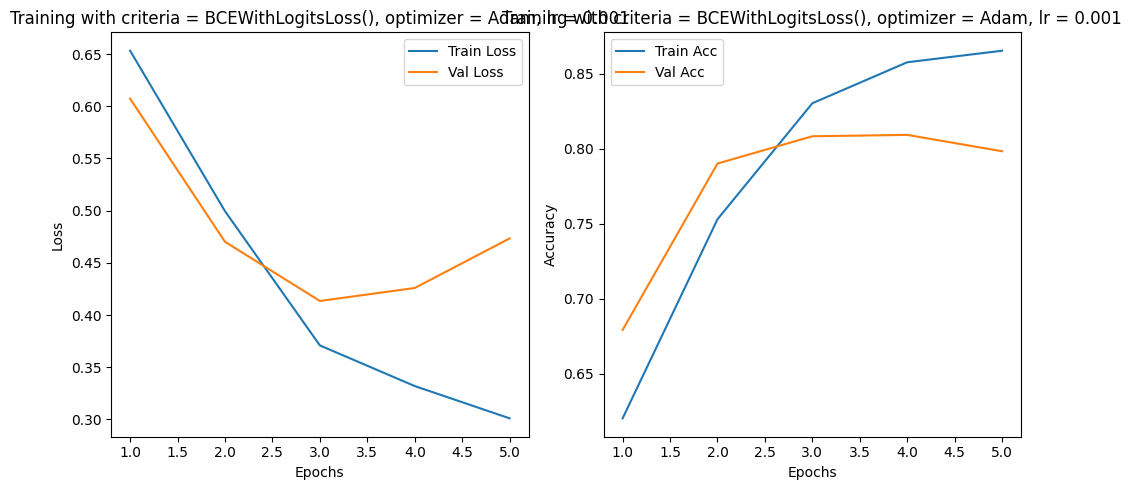

Training with criteria = BCEWithLogitsLoss(), optimizer = SGD, lr = 0.001
Epoch: 01 | Epoch Time: 0m 35s
	Train Loss: 0.695 | Train Acc: 46.63%
	 Val. Loss: 0.693 |  Val. Acc: 50.82%
Epoch: 02 | Epoch Time: 0m 35s
	Train Loss: 0.695 | Train Acc: 46.62%
	 Val. Loss: 0.693 |  Val. Acc: 52.18%
Epoch: 03 | Epoch Time: 0m 35s
	Train Loss: 0.695 | Train Acc: 46.56%
	 Val. Loss: 0.693 |  Val. Acc: 51.73%
Epoch: 04 | Epoch Time: 0m 37s
	Train Loss: 0.694 | Train Acc: 46.69%
	 Val. Loss: 0.693 |  Val. Acc: 51.64%
Epoch: 05 | Epoch Time: 0m 35s
	Train Loss: 0.694 | Train Acc: 46.60%
	 Val. Loss: 0.693 |  Val. Acc: 50.91%


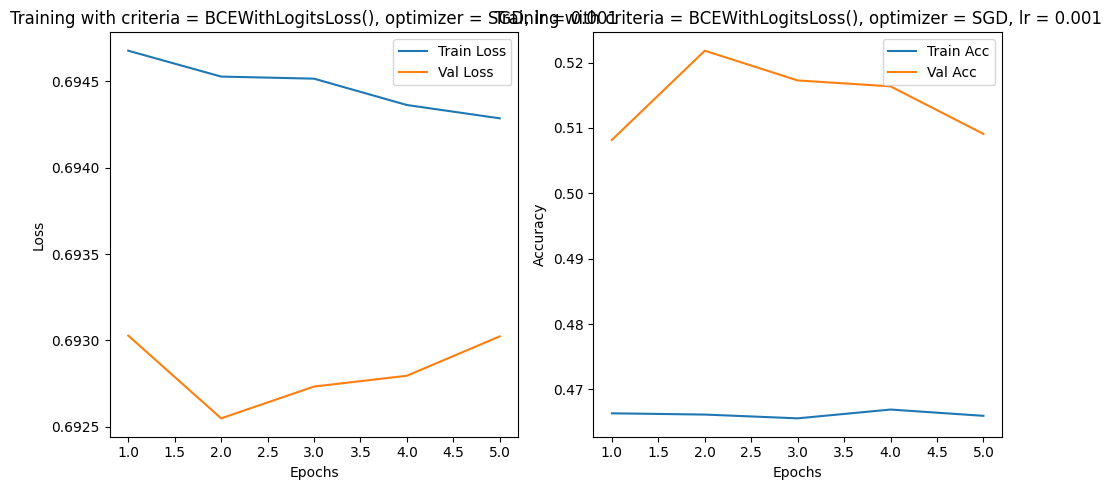

Training with criteria = BCEWithLogitsLoss(), optimizer = RMSprop, lr = 0.001
Epoch: 01 | Epoch Time: 0m 33s
	Train Loss: 0.639 | Train Acc: 64.37%
	 Val. Loss: 0.597 |  Val. Acc: 69.27%
Epoch: 02 | Epoch Time: 0m 33s
	Train Loss: 0.456 | Train Acc: 78.67%
	 Val. Loss: 0.516 |  Val. Acc: 78.55%
Epoch: 03 | Epoch Time: 0m 34s
	Train Loss: 0.372 | Train Acc: 83.60%
	 Val. Loss: 0.422 |  Val. Acc: 81.73%
Epoch: 04 | Epoch Time: 0m 34s
	Train Loss: 0.334 | Train Acc: 85.52%
	 Val. Loss: 0.421 |  Val. Acc: 80.09%
Epoch: 05 | Epoch Time: 0m 34s
	Train Loss: 0.308 | Train Acc: 86.94%
	 Val. Loss: 0.441 |  Val. Acc: 81.91%


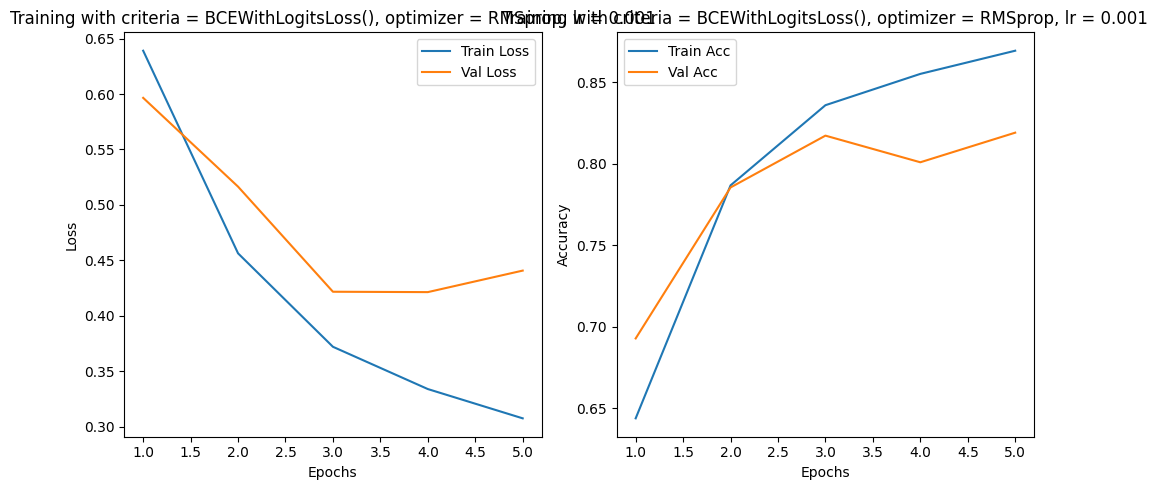

Training with criteria = BCEWithLogitsLoss(), optimizer = Adam, lr = 0.005
Epoch: 01 | Epoch Time: 0m 37s
	Train Loss: 0.622 | Train Acc: 64.90%
	 Val. Loss: 0.538 |  Val. Acc: 78.00%
Epoch: 02 | Epoch Time: 0m 36s
	Train Loss: 0.423 | Train Acc: 80.88%
	 Val. Loss: 0.444 |  Val. Acc: 80.09%
Epoch: 03 | Epoch Time: 0m 37s
	Train Loss: 0.348 | Train Acc: 85.00%
	 Val. Loss: 0.463 |  Val. Acc: 80.36%
Epoch: 04 | Epoch Time: 0m 36s
	Train Loss: 0.287 | Train Acc: 87.23%
	 Val. Loss: 0.488 |  Val. Acc: 81.27%
Epoch: 05 | Epoch Time: 0m 35s
	Train Loss: 0.252 | Train Acc: 88.77%
	 Val. Loss: 0.568 |  Val. Acc: 80.27%


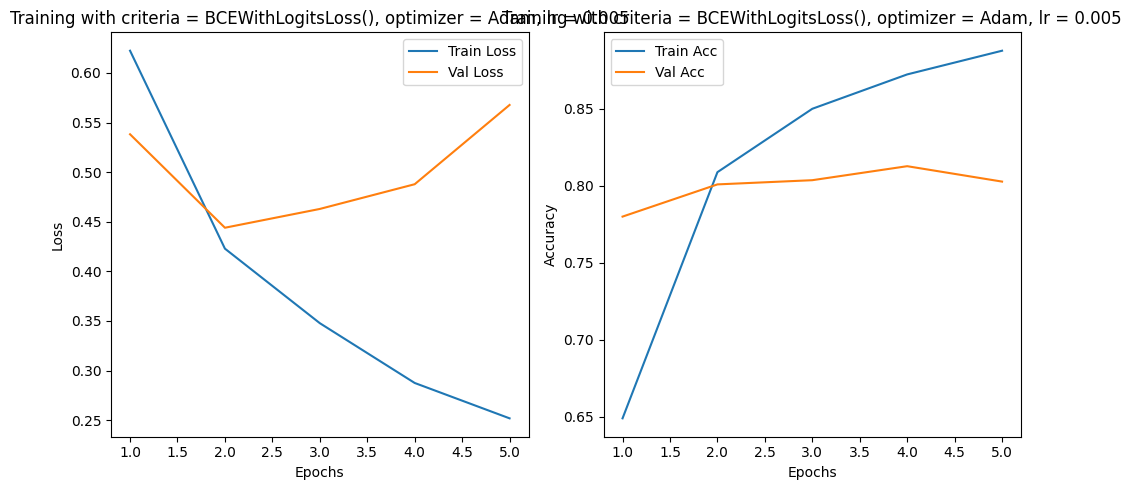

Training with criteria = BCEWithLogitsLoss(), optimizer = SGD, lr = 0.005
Epoch: 01 | Epoch Time: 0m 36s
	Train Loss: 0.692 | Train Acc: 53.15%
	 Val. Loss: 0.694 |  Val. Acc: 47.73%
Epoch: 02 | Epoch Time: 0m 37s
	Train Loss: 0.692 | Train Acc: 54.06%
	 Val. Loss: 0.694 |  Val. Acc: 48.64%
Epoch: 03 | Epoch Time: 0m 36s
	Train Loss: 0.692 | Train Acc: 53.40%
	 Val. Loss: 0.694 |  Val. Acc: 48.82%
Epoch: 04 | Epoch Time: 0m 35s
	Train Loss: 0.692 | Train Acc: 53.02%
	 Val. Loss: 0.694 |  Val. Acc: 48.73%
Epoch: 05 | Epoch Time: 0m 34s
	Train Loss: 0.691 | Train Acc: 53.46%
	 Val. Loss: 0.694 |  Val. Acc: 48.73%


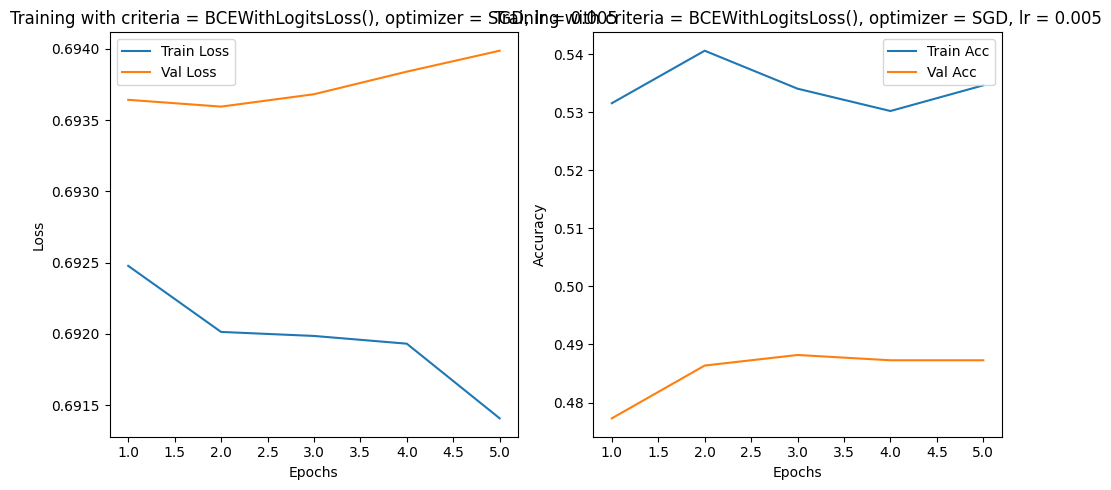

Training with criteria = BCEWithLogitsLoss(), optimizer = RMSprop, lr = 0.005
Epoch: 01 | Epoch Time: 0m 33s
	Train Loss: 0.911 | Train Acc: 53.19%
	 Val. Loss: 0.665 |  Val. Acc: 59.82%
Epoch: 02 | Epoch Time: 0m 34s
	Train Loss: 0.560 | Train Acc: 72.04%
	 Val. Loss: 0.500 |  Val. Acc: 76.55%
Epoch: 03 | Epoch Time: 0m 33s
	Train Loss: 0.437 | Train Acc: 80.52%
	 Val. Loss: 0.465 |  Val. Acc: 77.64%
Epoch: 04 | Epoch Time: 0m 32s
	Train Loss: 0.361 | Train Acc: 84.35%
	 Val. Loss: 0.481 |  Val. Acc: 77.36%
Epoch: 05 | Epoch Time: 0m 32s
	Train Loss: 0.315 | Train Acc: 86.42%
	 Val. Loss: 0.476 |  Val. Acc: 79.27%


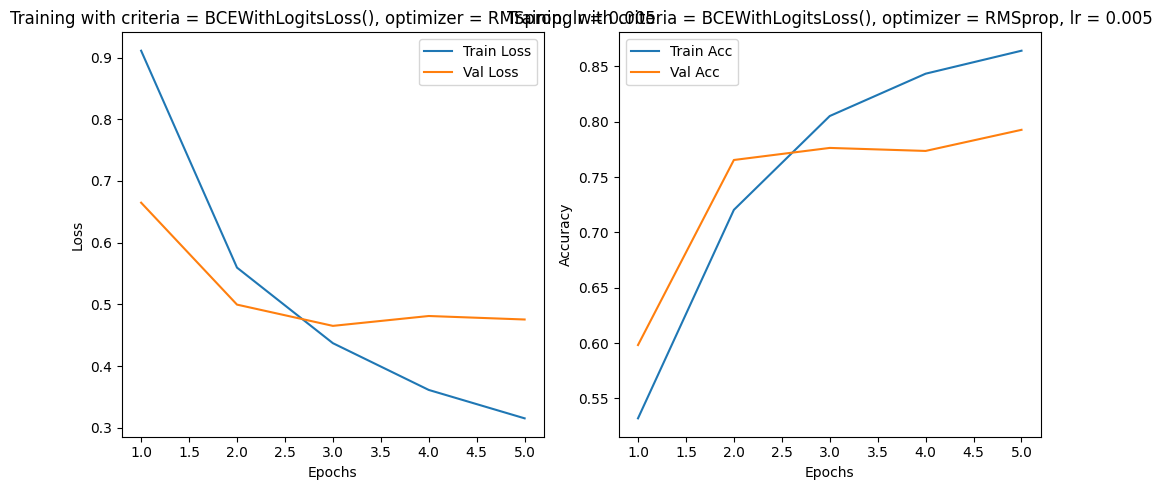

Training with criteria = BCEWithLogitsLoss(), optimizer = Adam, lr = 0.01
Epoch: 01 | Epoch Time: 0m 33s
	Train Loss: 0.611 | Train Acc: 67.38%
	 Val. Loss: 0.479 |  Val. Acc: 77.18%
Epoch: 02 | Epoch Time: 0m 33s
	Train Loss: 0.426 | Train Acc: 80.75%
	 Val. Loss: 0.472 |  Val. Acc: 77.09%
Epoch: 03 | Epoch Time: 0m 34s
	Train Loss: 0.356 | Train Acc: 83.98%
	 Val. Loss: 0.451 |  Val. Acc: 79.73%
Epoch: 04 | Epoch Time: 0m 35s
	Train Loss: 0.300 | Train Acc: 86.69%
	 Val. Loss: 0.506 |  Val. Acc: 80.45%
Epoch: 05 | Epoch Time: 0m 34s
	Train Loss: 0.256 | Train Acc: 88.40%
	 Val. Loss: 0.556 |  Val. Acc: 78.55%


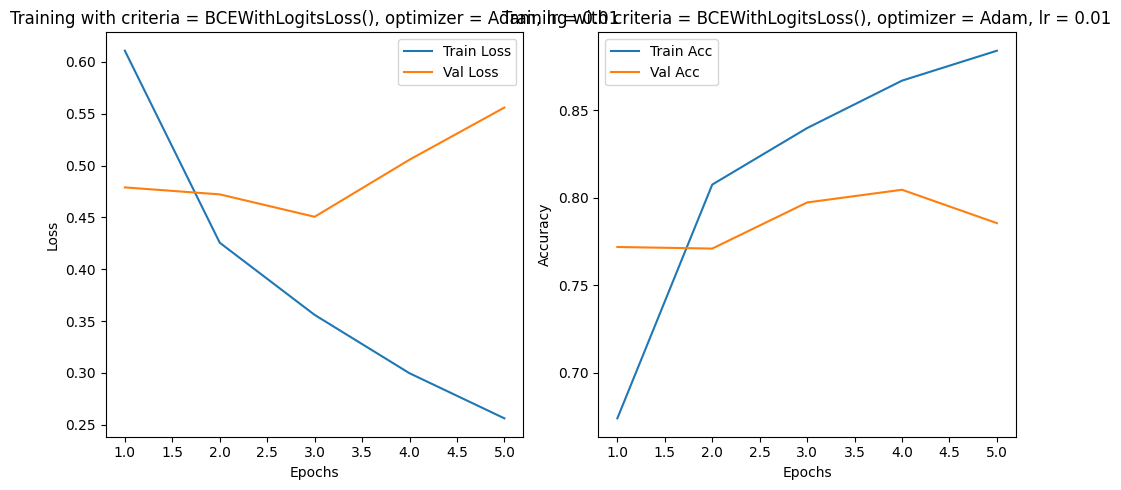

Training with criteria = BCEWithLogitsLoss(), optimizer = SGD, lr = 0.01
Epoch: 01 | Epoch Time: 0m 33s
	Train Loss: 0.692 | Train Acc: 53.38%
	 Val. Loss: 0.694 |  Val. Acc: 48.45%
Epoch: 02 | Epoch Time: 0m 34s
	Train Loss: 0.692 | Train Acc: 53.08%
	 Val. Loss: 0.694 |  Val. Acc: 49.00%
Epoch: 03 | Epoch Time: 0m 36s
	Train Loss: 0.692 | Train Acc: 52.96%
	 Val. Loss: 0.694 |  Val. Acc: 49.18%
Epoch: 04 | Epoch Time: 0m 34s
	Train Loss: 0.692 | Train Acc: 53.31%
	 Val. Loss: 0.695 |  Val. Acc: 49.09%
Epoch: 05 | Epoch Time: 0m 35s
	Train Loss: 0.692 | Train Acc: 53.08%
	 Val. Loss: 0.695 |  Val. Acc: 48.82%


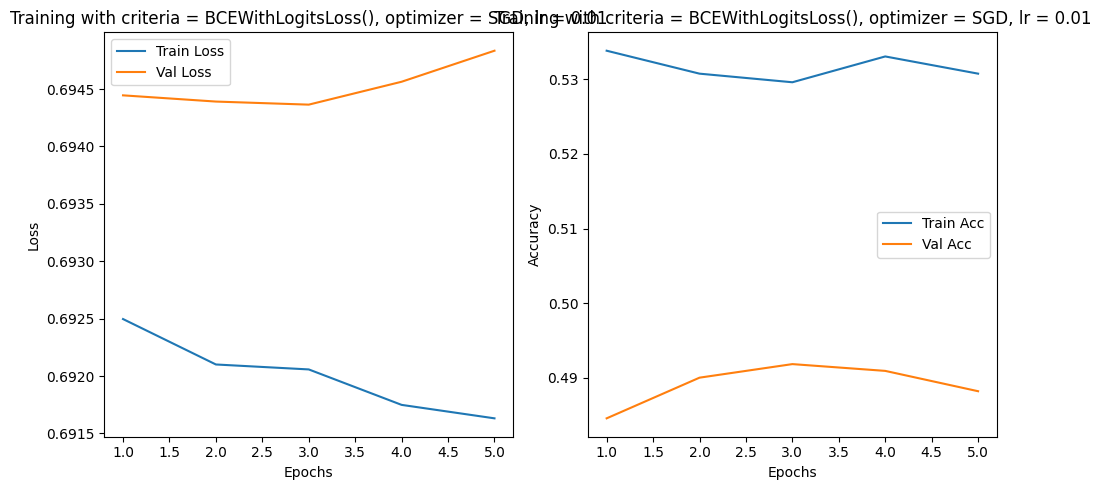

Training with criteria = BCEWithLogitsLoss(), optimizer = RMSprop, lr = 0.01
Epoch: 01 | Epoch Time: 1m 3s
	Train Loss: 1.270 | Train Acc: 58.52%
	 Val. Loss: 0.548 |  Val. Acc: 72.45%
Epoch: 02 | Epoch Time: 0m 59s
	Train Loss: 0.496 | Train Acc: 76.29%
	 Val. Loss: 0.513 |  Val. Acc: 75.91%
Epoch: 03 | Epoch Time: 0m 48s
	Train Loss: 0.419 | Train Acc: 81.08%
	 Val. Loss: 0.509 |  Val. Acc: 75.91%
Epoch: 04 | Epoch Time: 0m 44s
	Train Loss: 0.353 | Train Acc: 84.65%
	 Val. Loss: 0.507 |  Val. Acc: 76.64%
Epoch: 05 | Epoch Time: 0m 38s
	Train Loss: 0.362 | Train Acc: 83.79%
	 Val. Loss: 0.488 |  Val. Acc: 77.45%


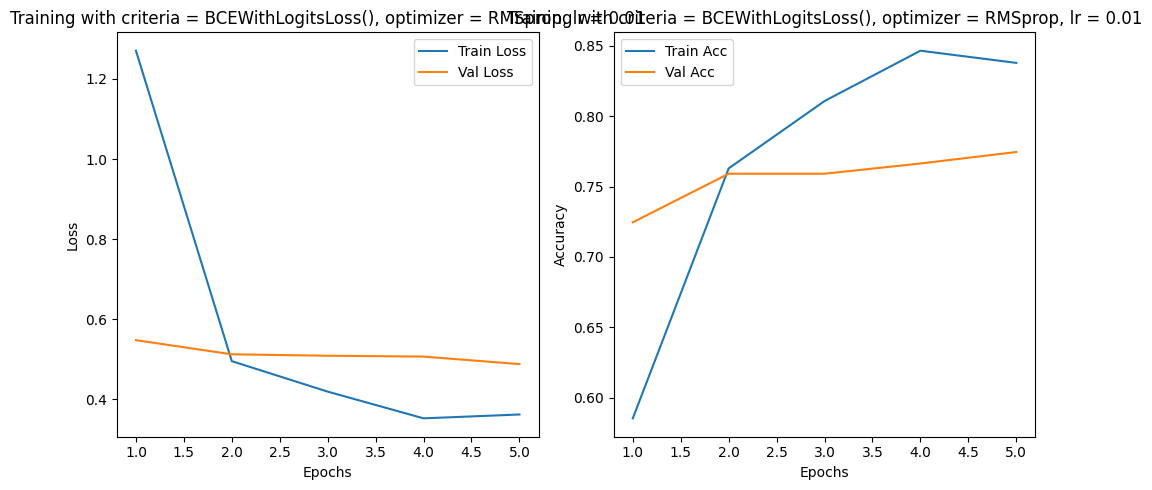

Training with criteria = BCELoss(), optimizer = Adam, lr = 0.001


RuntimeError: Found dtype Double but expected Float

In [ ]:
Tuning_model_RNN(learning_rate, criterias, optimizers, train_dataloader, valid_dataloader, device, num_epochs=5)

Training with HIDDEN_DIM=128, N_LAYERS=2, DROPOUT=0.3
Epoch: 01 | Epoch Time: 0m 16s
	Train Loss: 0.652 | Train Acc: 61.52%
	 Val. Loss: 0.604 |  Val. Acc: 69.72%
Epoch: 02 | Epoch Time: 0m 14s
	Train Loss: 0.518 | Train Acc: 74.35%
	 Val. Loss: 0.535 |  Val. Acc: 73.82%
Epoch: 03 | Epoch Time: 0m 16s
	Train Loss: 0.393 | Train Acc: 82.15%
	 Val. Loss: 0.440 |  Val. Acc: 79.87%
Epoch: 04 | Epoch Time: 0m 15s
	Train Loss: 0.344 | Train Acc: 85.16%
	 Val. Loss: 0.469 |  Val. Acc: 78.96%
Epoch: 05 | Epoch Time: 0m 16s
	Train Loss: 0.310 | Train Acc: 87.35%
	 Val. Loss: 0.435 |  Val. Acc: 80.67%
Epoch: 06 | Epoch Time: 0m 16s
	Train Loss: 0.285 | Train Acc: 88.06%
	 Val. Loss: 0.467 |  Val. Acc: 79.96%
Epoch: 07 | Epoch Time: 0m 15s
	Train Loss: 0.265 | Train Acc: 88.69%
	 Val. Loss: 0.474 |  Val. Acc: 81.81%
Epoch: 08 | Epoch Time: 0m 16s
	Train Loss: 0.248 | Train Acc: 89.61%
	 Val. Loss: 0.481 |  Val. Acc: 81.49%
Epoch: 09 | Epoch Time: 0m 16s
	Train Loss: 0.236 | Train Acc: 90.15%
	 Va

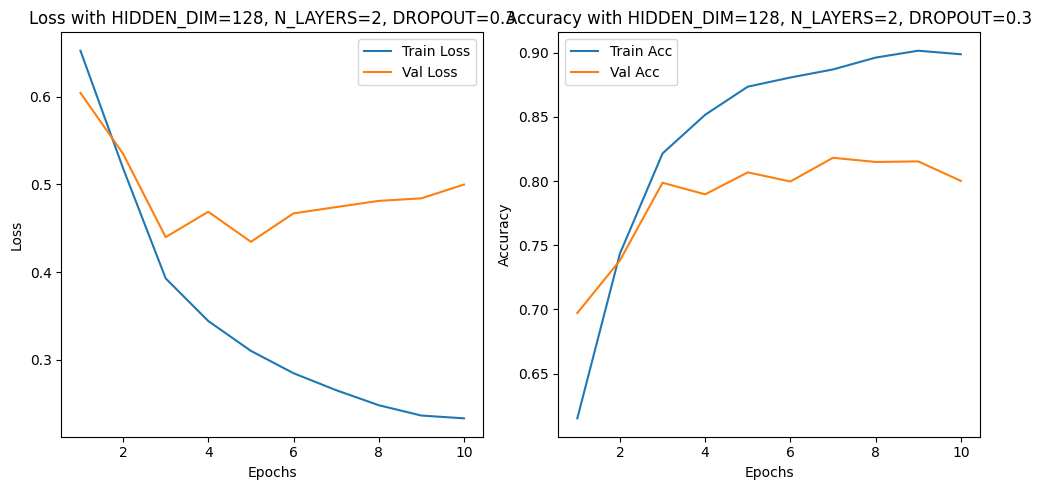

Training with HIDDEN_DIM=128, N_LAYERS=2, DROPOUT=0.5
Epoch: 01 | Epoch Time: 0m 16s
	Train Loss: 0.659 | Train Acc: 60.31%
	 Val. Loss: 0.619 |  Val. Acc: 67.68%
Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 0.577 | Train Acc: 70.19%
	 Val. Loss: 0.482 |  Val. Acc: 77.91%
Epoch: 03 | Epoch Time: 0m 15s
	Train Loss: 0.434 | Train Acc: 80.13%
	 Val. Loss: 0.460 |  Val. Acc: 78.87%
Epoch: 04 | Epoch Time: 0m 15s
	Train Loss: 0.372 | Train Acc: 83.43%
	 Val. Loss: 0.462 |  Val. Acc: 79.01%
Epoch: 05 | Epoch Time: 0m 15s
	Train Loss: 0.328 | Train Acc: 85.72%
	 Val. Loss: 0.450 |  Val. Acc: 80.25%
Epoch: 06 | Epoch Time: 0m 16s
	Train Loss: 0.311 | Train Acc: 86.79%
	 Val. Loss: 0.448 |  Val. Acc: 80.49%
Epoch: 07 | Epoch Time: 0m 15s
	Train Loss: 0.293 | Train Acc: 87.46%
	 Val. Loss: 0.434 |  Val. Acc: 81.53%
Epoch: 08 | Epoch Time: 0m 15s
	Train Loss: 0.274 | Train Acc: 88.20%
	 Val. Loss: 0.511 |  Val. Acc: 78.72%
Epoch: 09 | Epoch Time: 0m 15s
	Train Loss: 0.265 | Train Acc: 88.85%
	 Va

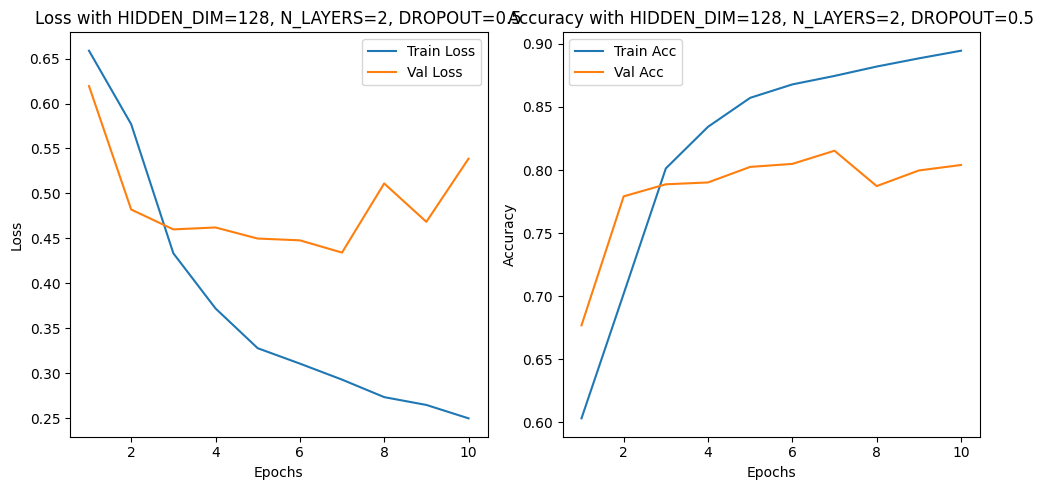

Training with HIDDEN_DIM=128, N_LAYERS=3, DROPOUT=0.3
Epoch: 01 | Epoch Time: 0m 23s
	Train Loss: 0.650 | Train Acc: 61.72%
	 Val. Loss: 0.581 |  Val. Acc: 69.02%
Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 0.511 | Train Acc: 74.92%
	 Val. Loss: 0.464 |  Val. Acc: 77.44%
Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 0.388 | Train Acc: 82.57%
	 Val. Loss: 0.430 |  Val. Acc: 79.58%
Epoch: 04 | Epoch Time: 0m 24s
	Train Loss: 0.333 | Train Acc: 85.76%
	 Val. Loss: 0.459 |  Val. Acc: 78.73%
Epoch: 05 | Epoch Time: 0m 24s
	Train Loss: 0.295 | Train Acc: 87.31%
	 Val. Loss: 0.457 |  Val. Acc: 79.77%
Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 0.275 | Train Acc: 88.32%
	 Val. Loss: 0.438 |  Val. Acc: 81.24%
Epoch: 07 | Epoch Time: 0m 24s
	Train Loss: 0.263 | Train Acc: 88.62%
	 Val. Loss: 0.466 |  Val. Acc: 80.87%
Epoch: 08 | Epoch Time: 0m 24s
	Train Loss: 0.248 | Train Acc: 89.67%
	 Val. Loss: 0.487 |  Val. Acc: 81.44%
Epoch: 09 | Epoch Time: 0m 24s
	Train Loss: 0.237 | Train Acc: 89.59%
	 Va

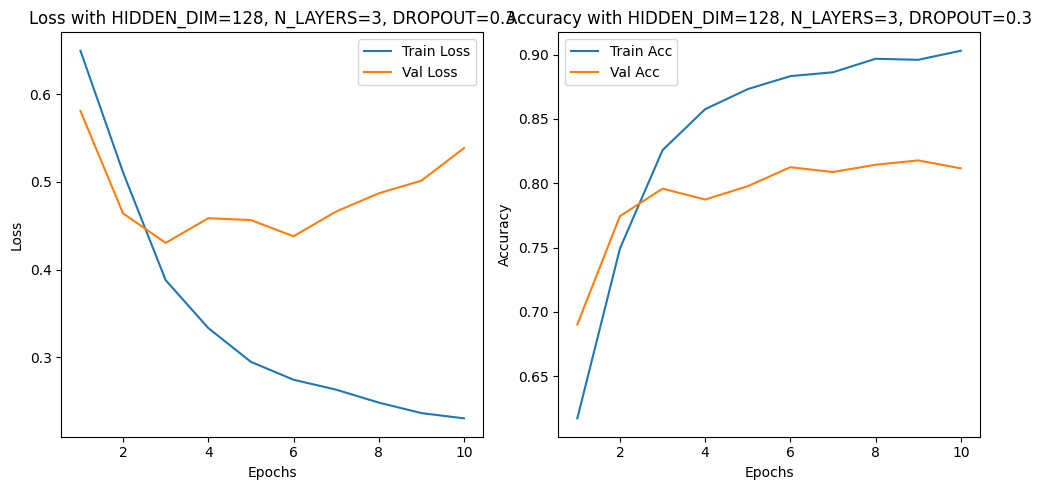

Training with HIDDEN_DIM=128, N_LAYERS=3, DROPOUT=0.5
Epoch: 01 | Epoch Time: 0m 23s
	Train Loss: 0.656 | Train Acc: 61.28%
	 Val. Loss: 0.610 |  Val. Acc: 68.59%
Epoch: 02 | Epoch Time: 0m 24s
	Train Loss: 0.544 | Train Acc: 73.30%
	 Val. Loss: 0.492 |  Val. Acc: 75.77%
Epoch: 03 | Epoch Time: 0m 24s
	Train Loss: 0.411 | Train Acc: 81.21%
	 Val. Loss: 0.459 |  Val. Acc: 78.49%
Epoch: 04 | Epoch Time: 0m 24s
	Train Loss: 0.358 | Train Acc: 84.03%
	 Val. Loss: 0.438 |  Val. Acc: 80.58%
Epoch: 05 | Epoch Time: 0m 24s
	Train Loss: 0.323 | Train Acc: 86.15%
	 Val. Loss: 0.431 |  Val. Acc: 80.44%
Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 0.303 | Train Acc: 86.83%
	 Val. Loss: 0.468 |  Val. Acc: 80.34%
Epoch: 07 | Epoch Time: 0m 24s
	Train Loss: 0.289 | Train Acc: 87.45%
	 Val. Loss: 0.475 |  Val. Acc: 80.11%
Epoch: 08 | Epoch Time: 0m 24s
	Train Loss: 0.279 | Train Acc: 87.93%
	 Val. Loss: 0.481 |  Val. Acc: 81.63%
Epoch: 09 | Epoch Time: 0m 24s
	Train Loss: 0.258 | Train Acc: 88.81%
	 Va

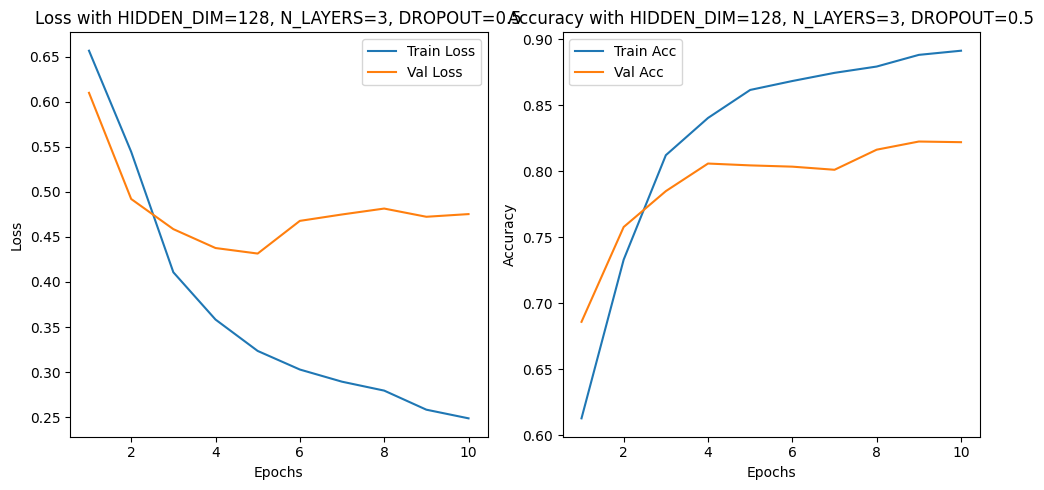

Training with HIDDEN_DIM=256, N_LAYERS=2, DROPOUT=0.3
Epoch: 01 | Epoch Time: 0m 37s
	Train Loss: 0.647 | Train Acc: 63.73%
	 Val. Loss: 0.594 |  Val. Acc: 69.16%
Epoch: 02 | Epoch Time: 0m 36s
	Train Loss: 0.501 | Train Acc: 75.22%
	 Val. Loss: 0.465 |  Val. Acc: 78.44%
Epoch: 03 | Epoch Time: 0m 36s
	Train Loss: 0.372 | Train Acc: 83.33%
	 Val. Loss: 0.505 |  Val. Acc: 78.68%
Epoch: 04 | Epoch Time: 0m 37s
	Train Loss: 0.331 | Train Acc: 85.44%
	 Val. Loss: 0.422 |  Val. Acc: 81.15%
Epoch: 05 | Epoch Time: 0m 38s
	Train Loss: 0.294 | Train Acc: 87.18%
	 Val. Loss: 0.446 |  Val. Acc: 80.86%
Epoch: 06 | Epoch Time: 0m 36s
	Train Loss: 0.272 | Train Acc: 88.24%
	 Val. Loss: 0.455 |  Val. Acc: 82.15%
Epoch: 07 | Epoch Time: 0m 36s
	Train Loss: 0.266 | Train Acc: 88.81%
	 Val. Loss: 0.476 |  Val. Acc: 80.20%
Epoch: 08 | Epoch Time: 0m 38s
	Train Loss: 0.258 | Train Acc: 88.58%
	 Val. Loss: 0.498 |  Val. Acc: 81.01%
Epoch: 09 | Epoch Time: 0m 39s
	Train Loss: 0.257 | Train Acc: 88.92%
	 Va

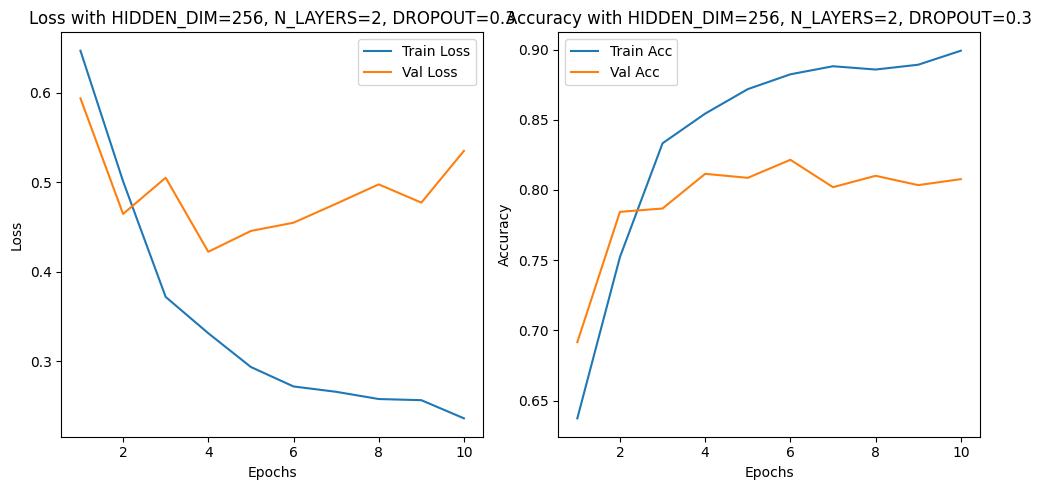

Training with HIDDEN_DIM=256, N_LAYERS=2, DROPOUT=0.5
Epoch: 01 | Epoch Time: 0m 38s
	Train Loss: 0.658 | Train Acc: 60.42%
	 Val. Loss: 0.598 |  Val. Acc: 70.49%
Epoch: 02 | Epoch Time: 0m 39s
	Train Loss: 0.531 | Train Acc: 73.24%
	 Val. Loss: 0.492 |  Val. Acc: 76.01%
Epoch: 03 | Epoch Time: 0m 37s
	Train Loss: 0.402 | Train Acc: 82.03%
	 Val. Loss: 0.457 |  Val. Acc: 77.92%
Epoch: 04 | Epoch Time: 0m 38s
	Train Loss: 0.355 | Train Acc: 84.60%
	 Val. Loss: 0.426 |  Val. Acc: 80.72%
Epoch: 05 | Epoch Time: 0m 38s
	Train Loss: 0.323 | Train Acc: 86.02%
	 Val. Loss: 0.447 |  Val. Acc: 80.63%
Epoch: 06 | Epoch Time: 0m 37s
	Train Loss: 0.299 | Train Acc: 87.24%
	 Val. Loss: 0.500 |  Val. Acc: 78.59%
Epoch: 07 | Epoch Time: 0m 36s
	Train Loss: 0.292 | Train Acc: 87.30%
	 Val. Loss: 0.454 |  Val. Acc: 80.58%
Epoch: 08 | Epoch Time: 0m 38s
	Train Loss: 0.277 | Train Acc: 87.84%
	 Val. Loss: 0.482 |  Val. Acc: 80.39%
Epoch: 09 | Epoch Time: 0m 38s
	Train Loss: 0.260 | Train Acc: 88.75%
	 Va

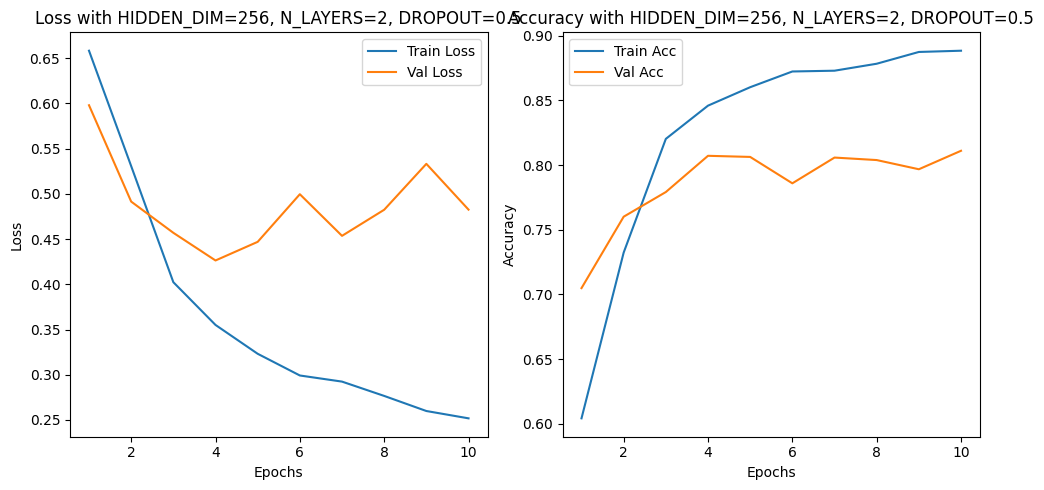

Training with HIDDEN_DIM=256, N_LAYERS=3, DROPOUT=0.3
Epoch: 01 | Epoch Time: 1m 1s
	Train Loss: 0.657 | Train Acc: 61.80%
	 Val. Loss: 0.603 |  Val. Acc: 67.68%
Epoch: 02 | Epoch Time: 0m 59s
	Train Loss: 0.504 | Train Acc: 75.26%
	 Val. Loss: 0.496 |  Val. Acc: 76.63%
Epoch: 03 | Epoch Time: 0m 59s
	Train Loss: 0.384 | Train Acc: 82.27%
	 Val. Loss: 0.441 |  Val. Acc: 79.10%
Epoch: 04 | Epoch Time: 0m 58s
	Train Loss: 0.328 | Train Acc: 85.61%
	 Val. Loss: 0.442 |  Val. Acc: 80.53%
Epoch: 05 | Epoch Time: 0m 59s
	Train Loss: 0.293 | Train Acc: 87.32%
	 Val. Loss: 0.507 |  Val. Acc: 81.58%
Epoch: 06 | Epoch Time: 0m 58s
	Train Loss: 0.286 | Train Acc: 87.50%
	 Val. Loss: 0.429 |  Val. Acc: 81.72%
Epoch: 07 | Epoch Time: 0m 59s
	Train Loss: 0.263 | Train Acc: 88.91%
	 Val. Loss: 0.515 |  Val. Acc: 81.06%
Epoch: 08 | Epoch Time: 0m 59s
	Train Loss: 0.243 | Train Acc: 89.63%
	 Val. Loss: 0.486 |  Val. Acc: 81.30%
Epoch: 09 | Epoch Time: 0m 58s
	Train Loss: 0.232 | Train Acc: 90.22%
	 Val

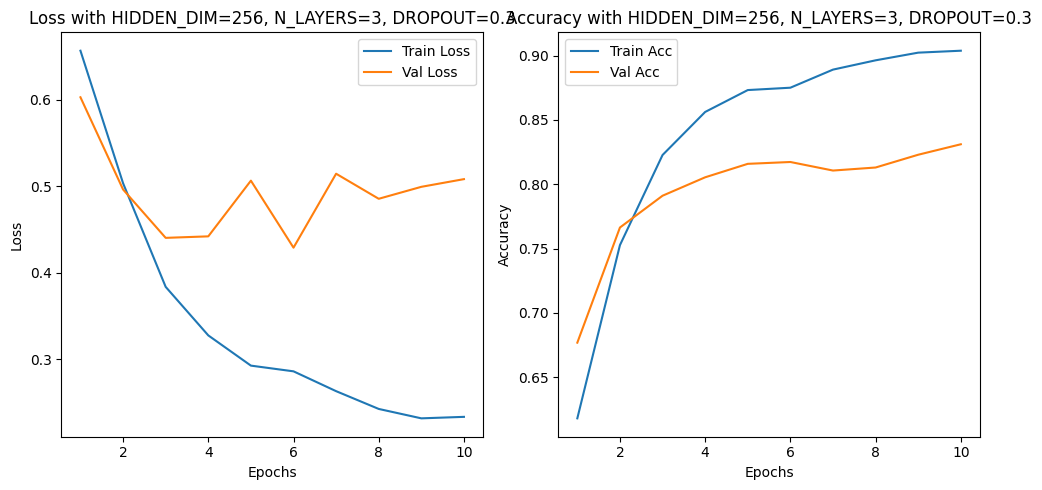

Training with HIDDEN_DIM=256, N_LAYERS=3, DROPOUT=0.5
Epoch: 01 | Epoch Time: 0m 57s
	Train Loss: 0.655 | Train Acc: 61.17%
	 Val. Loss: 0.614 |  Val. Acc: 67.73%
Epoch: 02 | Epoch Time: 0m 59s
	Train Loss: 0.535 | Train Acc: 73.07%
	 Val. Loss: 0.469 |  Val. Acc: 77.39%
Epoch: 03 | Epoch Time: 0m 57s
	Train Loss: 0.403 | Train Acc: 81.12%
	 Val. Loss: 0.449 |  Val. Acc: 79.15%
Epoch: 04 | Epoch Time: 0m 58s
	Train Loss: 0.339 | Train Acc: 84.93%
	 Val. Loss: 0.458 |  Val. Acc: 79.06%
Epoch: 05 | Epoch Time: 0m 56s
	Train Loss: 0.319 | Train Acc: 86.07%
	 Val. Loss: 0.440 |  Val. Acc: 79.63%
Epoch: 06 | Epoch Time: 0m 57s
	Train Loss: 0.295 | Train Acc: 87.02%
	 Val. Loss: 0.437 |  Val. Acc: 81.25%
Epoch: 07 | Epoch Time: 0m 56s
	Train Loss: 0.293 | Train Acc: 87.18%
	 Val. Loss: 0.476 |  Val. Acc: 80.20%
Epoch: 08 | Epoch Time: 0m 57s
	Train Loss: 0.267 | Train Acc: 88.46%
	 Val. Loss: 0.456 |  Val. Acc: 80.01%
Epoch: 09 | Epoch Time: 0m 55s
	Train Loss: 0.263 | Train Acc: 88.97%
	 Va

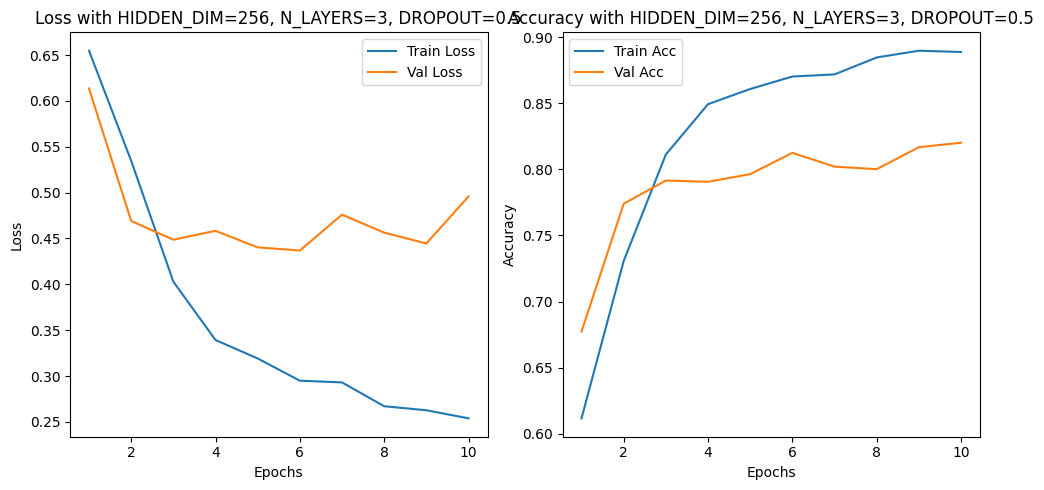

In [ ]:
import matplotlib.pyplot as plt


def train_model(HIDDEN_DIMs, N_LAYERSs, DROPOUTs, train_dataloader, valid_dataloader, num_epochs=10):
    Tloss = []
    Tacc = []
    Vloss = []
    Vacc = []
    best_valid_loss = float("inf")

    for HIDDEN_DIM in HIDDEN_DIMs:
        for N_LAYERS in N_LAYERSs:
            for DROPOUT in DROPOUTs:
                print(f"Training with HIDDEN_DIM={HIDDEN_DIM}, N_LAYERS={N_LAYERS}, DROPOUT={DROPOUT}")

                INPUT_DIM = word_embedding.vectors.shape[0]
                EMBEDDING_DIM = 100
                BATCH_SIZE = 10
                HIDDEN_DIM = HIDDEN_DIM
                N_LAYERS = N_LAYERS
                BIDIRECTIONAL = True
                DROPOUT = DROPOUT
                PAD_IDX = vocab["<pad>"]
                UNK_IDX = vocab["<unk>"]

                model = RNN(INPUT_DIM,
                            EMBEDDING_DIM,
                            HIDDEN_DIM,
                            N_LAYERS,
                            BIDIRECTIONAL,
                            DROPOUT,
                            PAD_IDX)
                model.embedding.weight.data.copy_(word_embedding.vectors)
                model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
                model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)


                # Khởi tạo optimizer và hàm loss
                optimizer = optim.Adam(model.parameters(), lr = 0.001)
                criterion = nn.BCEWithLogitsLoss().to(device)

                train_losses = []
                train_accs = []
                val_losses = []
                val_accs = []

                for epoch in range(num_epochs):
                  start_time = time.time()

                  train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
                  valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion, device)

                  train_losses.append(train_loss)
                  train_accs.append(train_acc)
                  val_losses.append(valid_loss)
                  val_accs.append(valid_acc)

                  Tloss.append(train_loss)
                  Tacc.append(train_acc)
                  Vloss.append(valid_loss)
                  Vacc.append(valid_acc)

                  end_time = time.time()

                  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

                  if valid_loss < best_valid_loss:
                      best_valid_loss = valid_loss
                      torch.save(model.state_dict(), "model1.pt")

                  print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
                  print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
                  print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")



                # Vẽ biểu đồ
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
                plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.title(f"Loss with HIDDEN_DIM={HIDDEN_DIM}, N_LAYERS={N_LAYERS}, DROPOUT={DROPOUT}")
                plt.legend()

                plt.subplot(1, 2, 2)
                plt.plot(range(1, num_epochs + 1), train_accs, label='Train Acc')
                plt.plot(range(1, num_epochs + 1), val_accs, label='Val Acc')
                plt.xlabel('Epochs')
                plt.ylabel('Accuracy')
                plt.title(f"Accuracy with HIDDEN_DIM={HIDDEN_DIM}, N_LAYERS={N_LAYERS}, DROPOUT={DROPOUT}")
                plt.legend()

                plt.tight_layout()
                plt.show()

# Sử dụng hàm train_model với các giá trị hyperparameters
HIDDEN_DIMs = [128, 256]
N_LAYERSs = [2, 3]
DROPOUTs = [0.3, 0.5]

train_model(HIDDEN_DIMs, N_LAYERSs, DROPOUTs, train_dataloader, valid_dataloader, num_epochs = 10)

# Final RNN model

- hidden-dim = 256
- n-layers = 2
- dropout = 0.3
- optim = Adam
- loss Function = BCELogistsloss()
- learning-rate = 0.001

In [ ]:
INPUT_DIM = word_embedding.vectors.shape[0]
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.3
PAD_IDX = vocab["<pad>"]
UNK_IDX = vocab["<unk>"]

model = RNN(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)
model.embedding.weight.data.copy_(word_embedding.vectors)
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [ ]:
model.to(device)

RNN(
  (embedding): Embedding(6250, 100, padding_idx=0)
  (rnn): LSTM(100, 256, num_layers=2, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [ ]:
# Khởi tạo optimizer và hàm loss
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.BCEWithLogitsLoss().to(device)

In [ ]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_valid_loss = float("inf")

for epoch in range(15):
  start_time = time.time()

  train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion, device)

  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(valid_loss)
  val_accs.append(valid_acc)

  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), "Best_model_RNN.pt")

  print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
  print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
  print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 0.655 | Train Acc: 61.38%
	 Val. Loss: 0.594 |  Val. Acc: 68.82%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.491 | Train Acc: 76.38%
	 Val. Loss: 0.434 |  Val. Acc: 78.91%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.375 | Train Acc: 82.85%
	 Val. Loss: 0.415 |  Val. Acc: 81.55%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.324 | Train Acc: 85.87%
	 Val. Loss: 0.399 |  Val. Acc: 82.73%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.301 | Train Acc: 86.63%
	 Val. Loss: 0.433 |  Val. Acc: 81.18%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 0.273 | Train Acc: 88.31%
	 Val. Loss: 0.442 |  Val. Acc: 81.73%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.268 | Train Acc: 88.12%
	 Val. Loss: 0.440 |  Val. Acc: 81.36%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.258 | Train Acc: 88.35%
	 Val. Loss: 0.484 |  Val. Acc: 81.36%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.235 | Train Acc: 89.56%
	 Val. Loss: 0.550 |  Val. Acc: 81.91%
Epoch: 10 | Epoch Time: 0m 0

# 9. Test the model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predict_sentiment(model, sentence, vocab, device):
    model.eval()
    corpus = [sentence]
    tensor = vocab.corpus_to_tensor(corpus)[0].to(device)
    tensor = tensor.unsqueeze(1)
    length = [len(tensor)]
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

In [ ]:
df = pd.read_csv("test.csv")

In [ ]:
def pred(text):
  pred = predict_sentiment(model, text, vocab, device)
  if pred >= 0.5 : return "positive"
  else : return "negative"

In [ ]:
df["pred"] = df["vi_review"].apply(pred)

In [ ]:
pre = df[df["sentiment"] != df["pred"]]

In [ ]:
print(f"Acc of test dataset is {round(100 -(len(pre) / len(df))*100,2)}%")

Acc of test dataset is 84.11%
